Changing display options (important!)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

## Imports and data

In [4]:
path = 'data/mnist/'

In [5]:
import os
os.makedirs(path, exist_ok=True)

In [6]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [7]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [8]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

In [9]:
mean = x.mean()
std = x.std()

In [10]:
x = (x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

In [11]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

#### Useful Methods

In [12]:
def show(img, title=None):
    plt.imshow(img, cmap='gray')
    if title is not None: plt.title(title)

In [13]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

#### Plots

In [14]:
x_valid.shape

(10000, 784)

In [15]:
x_imgs = np.reshape(x_valid, (-1, 28, 28)); x_imgs.shape

(10000, 28, 28)

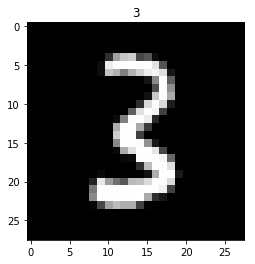

In [16]:
show(x_imgs[0], y_valid[0])

Looking at the part of an image:

In [17]:
x_imgs[0,10:15,10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

In [18]:
x_imgs[0:2,10:15,10:15]

array([[[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
        [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
        [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
        [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
        [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]],

       [[ 2.52465, -0.04316, -0.42452, -0.42452, -0.42452],
        [ 2.7916 ,  2.29584, -0.05587, -0.42452, -0.42452],
        [ 1.7238 ,  2.7916 ,  2.33397, -0.10672, -0.42452],
        [-0.25926,  2.00346,  2.80432,  2.34669,  1.26617],
        [-0.42452, -0.24655,  1.38058,  2.80432,  2.7916 ]]], dtype=float32)

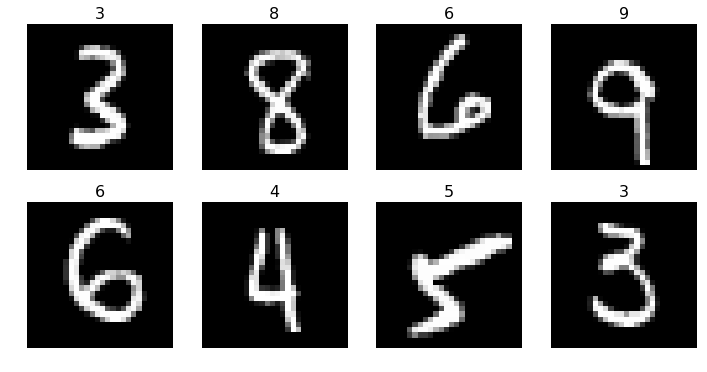

In [19]:
plots(x_imgs[:8], titles=y_valid[:8])

## Defining Logistic Regression for Neural Net

In [20]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

In [21]:
md = ImageClassifierData.from_arrays(path, (x, y), (x_valid, y_valid))

In [22]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])

In [23]:
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

In [24]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)   # Layer 1 weights
        self.l1_b = get_weights(10)          # Layer 1 bias
        
    def forward(self, x):
        x = x.view(x.size(0), -1)   # Reshaping
        x = (x @ self.l1_w) + self.l1_b   # Linear Layer
        x = torch.log(softmax(x))    # Non-linear (LogSoftmax) Layer
        return x

In [25]:
net = LogReg().cuda()
opt = optim.Adam(net.parameters())

In [26]:
# data loader
dl = iter(md.trn_dl)

In [27]:
xmb, ymb = next(dl)

In [28]:
# create Variable
vxmb = Variable(xmb.cuda())
vxmb

tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        ...,
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]],
       device='cuda:0')

In [29]:
preds = net(vxmb).exp(); preds[:3]

tensor([[0.1014, 0.1006, 0.0934, 0.1031, 0.1155, 0.0765, 0.1214, 0.0893, 0.0958,
         0.1030],
        [0.1016, 0.1008, 0.0971, 0.1061, 0.1116, 0.0706, 0.1180, 0.0925, 0.0965,
         0.1052],
        [0.0998, 0.1027, 0.1016, 0.1016, 0.1106, 0.0796, 0.1103, 0.0897, 0.0971,
         0.1070]], device='cuda:0', grad_fn=<SliceBackward>)

In [30]:
preds = preds.data.max(1)[1]; preds[:3]

tensor([6, 6, 4], device='cuda:0')

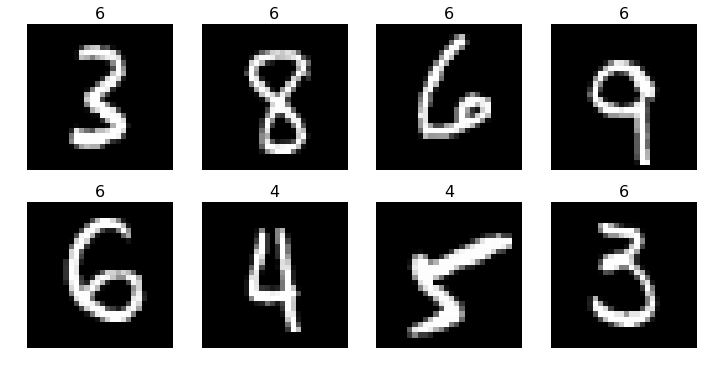

In [31]:
preds = predict(net, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [32]:
np.mean(preds == y_valid)

0.0944

## Writing Our Own Training Loop

In [33]:
# Our code from above
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b 
        return torch.log(softmax(x))

net = LogReg().cuda()
opt=optim.Adam(net.parameters())

We will use the LogReg class we created, as well as the same loss function, learning rate, and optimizer as before:

In [34]:
net = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net.parameters(), lr=learning_rate)

In [35]:
dl = iter(md.trn_dl) # Data loader

First, we will do a __forward pass__, which means computing the predicted y by passing x to the model.

In [36]:
xt, yt = next(dl)
y_pred = net(Variable(xt).cuda())

In [37]:
# loss
l = loss(y_pred, Variable(yt).cuda())
print(l)

tensor(2.3050, device='cuda:0', grad_fn=<NllLossBackward>)


In [38]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.140625

In [39]:
# Before the backward pass, use the optimizer object to zero all of the
# gradients for the variables it will update (which are the learnable weights
# of the model)
optimizer.zero_grad()

# Backward pass: compute gradient of the loss with respect to model parameters
l.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

Now, let's make another set of predictions and check if our loss is lower:

In [40]:
xt, yt = next(dl)
y_pred = net(Variable(xt).cuda())

In [41]:
l = loss(y_pred, Variable(yt).cuda())
print(l)

tensor(2.2052, device='cuda:0', grad_fn=<NllLossBackward>)


Note that we are using __stochastic gradient descent__, so the loss is not guaranteed to be strictly better each time. The stochasticity comes from the fact that we are using __mini-batches__; we are just using 64 images to calculate our prediction and update the weights, not the whole dataset.

In [42]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.15625

If we run several iterations in a loop, we should see the loss decrease and the accuracy increase with time.

In [43]:
for t in range(100):
    xt, yt = next(dl)
    y_pred = net(Variable(xt).cuda())
    l = loss(y_pred, Variable(yt).cuda())
    
    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        print("loss: ", l.data, "\t accuracy: ", accuracy)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

loss:  tensor(2.2450, device='cuda:0') 	 accuracy:  0.125
loss:  tensor(1.2260, device='cuda:0') 	 accuracy:  0.71875
loss:  tensor(0.9854, device='cuda:0') 	 accuracy:  0.78125
loss:  tensor(0.8616, device='cuda:0') 	 accuracy:  0.78125
loss:  tensor(0.7142, device='cuda:0') 	 accuracy:  0.84375
loss:  tensor(0.6101, device='cuda:0') 	 accuracy:  0.828125
loss:  tensor(0.5710, device='cuda:0') 	 accuracy:  0.8125
loss:  tensor(0.4492, device='cuda:0') 	 accuracy:  0.890625
loss:  tensor(0.5579, device='cuda:0') 	 accuracy:  0.828125
loss:  tensor(0.6649, device='cuda:0') 	 accuracy:  0.796875


### Putting it all together in a training loop

In [44]:
def score(x, y):
    y_pred = to_np(net(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [45]:
net = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net.parameters(), lr=learning_rate)

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(md.trn_dl)):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(md.val_dl))]
    print(np.mean(val_scores))

0.910828025477707


### Stochastic Gradient Descent

Nearly all of deep learning is powered by one very important algorithm: __stochastic gradient descent (SGD)__. SGD can be seeing as an approximation of __gradient descent (GD)__. In GD we have to run through all the samples in your training set to do a single itaration. In SGD we use only a subset of training samples to do the update for a parameter in a particular iteration. The subset used in each iteration is called a batch or minibatch.

Now, instead of using the optimizer, we will do the optimization ourselves!

In [46]:
net = LogReg().cuda()
loss_fn=nn.NLLLoss()
lr = 1e-2
w,b = net.l1_w,net.l1_b

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(md.trn_dl)):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
        w.grad.data.zero_()
        b.grad.data.zero_()   

    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(md.val_dl))]
    print(np.mean(val_scores))

0.910828025477707
